### 이 데이터셋의 치명적인 문제점 3가지
1. 라벨링의 신뢰도 바닥 (Subjective Labeling)
이 데이터는 전문 의사가 진단한 게 아닙니다. 일반 부모들이 앱을 통해 "우리 애가 배고픈 것 같아요" 하고 올린 데이터입니다.
부모조차도 '졸린 것(tired)'과 '배고픈 것(hungry)'을 자주 헷갈립니다. 즉, 정답지(Label) 자체가 틀려 있을 확률이 매우 높습니다.
사람도 구분 못 하는 걸 딥러닝 모델에게 구분하라고 하니, 모델은 혼란에 빠져 정확도 30%대에서 멈추는 것입니다.
2. 클래스 간의 모호성 (Ambiguity)
discomfort(불편함)와 belly_pain(복통)의 차이가 뭘까요? 소리만 듣고 이걸 구분하는 건 사실상 불가능에 가깝습니다.
burping(트림 필요)과 hungry(배고픔)도 소리 패턴이 매우 유사합니다.
3. 데이터 불균형과 잡음
hungry만 압도적으로 많고, 나머지는 적습니다. 게다가 집안 소음(TV, 말소리)이 섞여 있어 전처리가 매우 까다롭습니다.

### 데이터셋 변경
https://www.upf.edu/web/ntsa/downloads/-/asset_publisher/xvT6E4pczrBw/content/2012-nonrandomness-nonlinear-dependence-and-nonstationarity-of-electroencephalographic-recordings-from-epilepsy-patients

### 전처리

#### 경로 설정

In [2]:
# 1. 라이브러리 설치
!pip install timm -q

In [3]:
# 2. import
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import scipy.signal as signal
from scipy.io.wavfile import write
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
import IPython.display as ipd
from google.colab import drive

In [4]:
# 3. 드라이브 마운트
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 System Ready. Device: {device}")

Mounted at /content/drive
🔥 System Ready. Device: cpu


In [5]:
# 4. 드라이브 경로
input_f_dir = '/content/drive/MyDrive/Data_F_Ind_1_3750'  # 뇌전증 (Focal)
input_n_dir = '/content/drive/MyDrive/Data_N_Ind_1_3750'  # 정상 (Non-Focal)
output_dir = '/content/drive/MyDrive/Brain_Audio_Project_WAV' # 변환된 WAV 저장 경로

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"📂 저장 폴더 생성: {output_dir}")

#### 2. 텍스트 ➔ WAV 변환

In [9]:
# 1. 밴드패스 필터 (0.5 ~ 60Hz: 뇌파 핵심 대역만 남김)
def butter_bandpass_filter(data, lowcut=0.5, highcut=60, fs=173.61, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.filtfilt(b, a, data)
    return y

# 2. 변환 함수
def convert_drive_txt_to_wav(input_dir, output_dir, label_name, target_sr=16000):
    files = sorted(glob.glob(os.path.join(input_dir, '*.txt')))
    print(f"📂 '{label_name}' 데이터 처리 중... ({len(files)}개)")

    saved_paths = []

    for file in tqdm(files):
        try:
            # 텍스트 읽기 (콤마 구분 혹은 공백 구분 자동 처리)
            try:
                df = pd.read_csv(file, header=None, sep=',', engine='c')
            except:
                df = pd.read_csv(file, header=None, sep='\s+', engine='python')

            # 데이터가 여러 열이면 평균, 아니면 1열 사용
            if df.shape[1] >= 2:
                sig = df.mean(axis=1).values
            else:
                sig = df.iloc[:, 0].values.flatten()

            # 필터링 + 정규화
            sig = butter_bandpass_filter(sig) # 필터링

            # Robust Scaling (튀는 값 제거)
            limit = np.percentile(np.abs(sig), 99) # 상위 99% 값 기준
            sig = np.clip(sig, -limit, limit)

            # -1 ~ 1 정규화
            sig = sig / (np.max(np.abs(sig)) + 1e-8)

            # 저장
            filename = os.path.basename(file).replace('.txt', '.wav')
            save_path = os.path.join(output_dir, f"{label_name}_{filename}")

            # 이미 있으면 스킵 (시간 절약)
            if not os.path.exists(save_path):
                write(save_path, target_sr, sig.astype(np.float32))

            saved_paths.append(save_path)
        except Exception as e:
            continue

    return saved_paths

# 실행
files_f = convert_drive_txt_to_wav(input_f_dir, output_dir, "Focal")
files_n = convert_drive_txt_to_wav(input_n_dir, output_dir, "Normal")

print(f"✅ 변환 완료! 총 {len(files_f) + len(files_n)}개의 파일이 준비되었습니다.")

📂 'Focal' 데이터 처리 중... (750개)


<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-751485810.py:23: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file, header=None, sep='\s+', engine='python')


  0%|          | 0/750 [00:00<?, ?it/s]

📂 'Normal' 데이터 처리 중... (750개)


  0%|          | 0/750 [00:00<?, ?it/s]

✅ 변환 완료! 총 1500개의 파일이 준비되었습니다.


#### 소리, 파형, 주파수, t-SNE 시각화

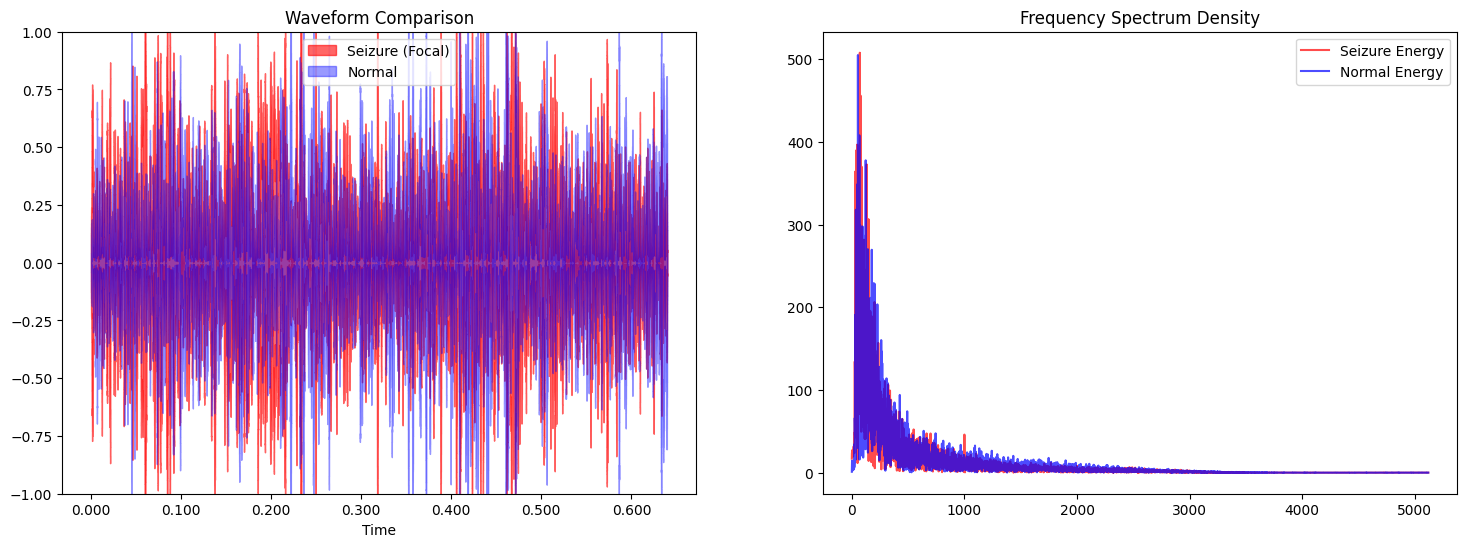

🎧 [청취] 1. 뇌전증 소리


🎧 [청취] 2. 정상 소리


In [10]:
# 1. 오디오 신호 비교 (Time & Frequency)
def visualize_signal_compare(f_path, n_path):
    y_f, sr = librosa.load(f_path, sr=None)
    y_n, sr = librosa.load(n_path, sr=None)

    plt.figure(figsize=(18, 6))

    # 파형 (Waveform)
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y_f, sr=sr, color='red', alpha=0.6, label='Seizure (Focal)')
    librosa.display.waveshow(y_n, sr=sr, color='blue', alpha=0.4, label='Normal')
    plt.title("Waveform Comparison")
    plt.legend()
    plt.ylim(-1, 1)

    # 주파수 스펙트럼 (FFT)
    plt.subplot(1, 2, 2)
    fft_f = np.abs(np.fft.rfft(y_f))
    fft_n = np.abs(np.fft.rfft(y_n))
    plt.plot(fft_f, color='red', alpha=0.7, label='Seizure Energy')
    plt.plot(fft_n, color='blue', alpha=0.7, label='Normal Energy')
    plt.title("Frequency Spectrum Density")
    plt.legend()
    plt.show()

    print("🎧 [청취] 1. 뇌전증 소리")
    display(ipd.Audio(f_path))
    print("🎧 [청취] 2. 정상 소리")
    display(ipd.Audio(n_path))

if len(files_f) > 0 and len(files_n) > 0:
    visualize_signal_compare(files_f[0], files_n[0])

# 2. t-SNE 시각화 함수 (나중에 데이터 로더 만든 뒤 실행됨)
def visualize_tsne(loader):
    features, labels = [], []
    print("⏳ t-SNE 시각화 생성 중 (데이터 분포 확인)...")

    for x, y in loader:
        # (Batch, 4, 224, 224) -> (Batch, Flat)
        flat = x.view(x.size(0), -1).numpy()
        features.extend(flat)
        labels.extend(y.numpy())
        if len(features) > 200: break # 속도를 위해 200개만 샘플링

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embedded = tsne.fit_transform(np.array(features))

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embedded[:,0], embedded[:,1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title("t-SNE Visualization (Data Distribution)")
    plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Seizure'])
    plt.show()

#### 4채널 데이터셋 구축
- 멜 스펙트로그램, MFCC, Contrast, ZCR 묶기

⏳ t-SNE 시각화 생성 중 (데이터 분포 확인)...


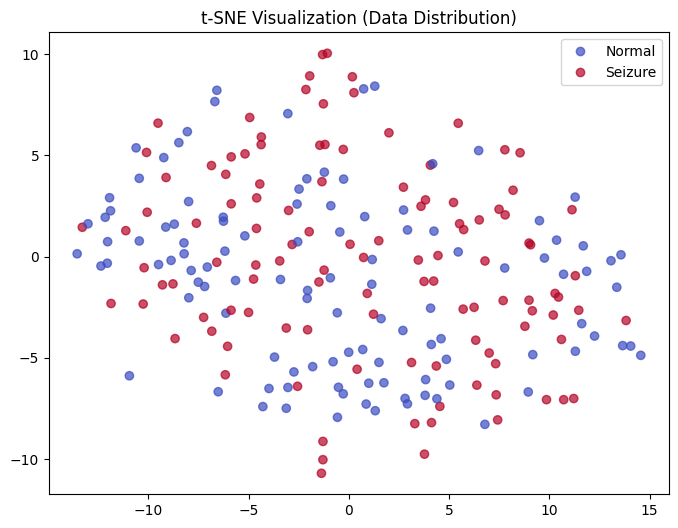

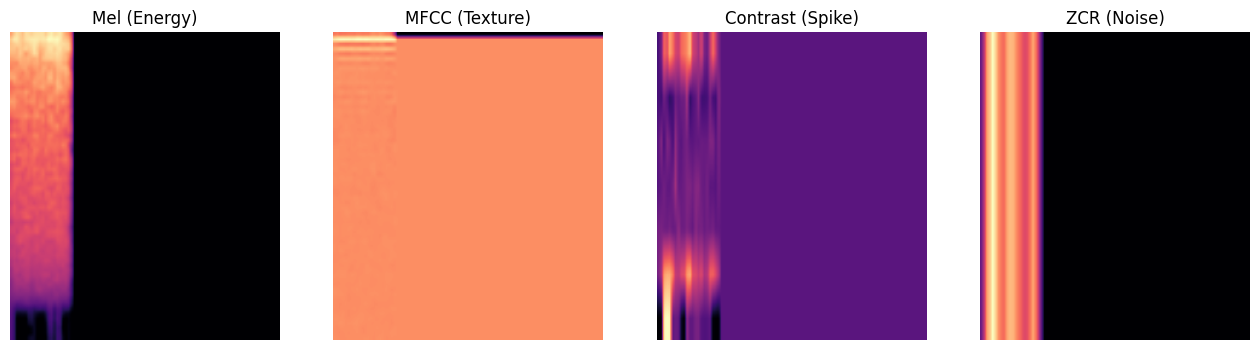

In [13]:
CONFIG = {
    'sr': 16000,
    'duration': 3,
    'n_mels': 64,
    'img_size': 224,
    'batch_size': 32
}

class BrainAudioDataset(Dataset):
    def __init__(self, file_list, labels, config, mode='train'):
        self.file_list = file_list
        self.labels = labels
        self.config = config
        self.mode = mode
        self.resize = T.Resize((config['img_size'], config['img_size']), antialias=True)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        label = self.labels[idx]

        try:
            y, sr = librosa.load(path, sr=self.config['sr'])

            # Trim (묵음 제거)
            y, _ = librosa.effects.trim(y, top_db=20)

            # Padding / Cutting
            target_len = int(self.config['sr'] * self.config['duration'])
            if len(y) < target_len:
                y = np.pad(y, (0, target_len - len(y)), mode='constant')
            else:
                start = np.random.randint(0, len(y) - target_len) if self.mode == 'train' else (len(y)-target_len)//2
                y = y[start:start+target_len]

            # --- 4-Channel Feature Extraction ---
            # 1. Mel-Spec
            mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.config['n_mels'])
            ch1 = librosa.power_to_db(mel, ref=np.max)

            # 2. MFCC
            ch2 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.config['n_mels'])

            # 3. Spectral Contrast
            contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6)
            contrast = torch.tensor(contrast).unsqueeze(0).unsqueeze(0)
            ch3 = F.interpolate(contrast, size=(self.config['n_mels'], ch1.shape[1]), mode='bilinear').squeeze().numpy()

            # 4. Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y)
            ch4 = np.tile(zcr, (self.config['n_mels'], 1))
            ch4 = librosa.util.fix_length(ch4, size=ch1.shape[1], axis=1)

            # Stack & Normalize (Channel-wise)
            img = np.stack([ch1, ch2, ch3, ch4], axis=0)
            for c in range(4):
                img[c] = (img[c] - img[c].min()) / (img[c].max() - img[c].min() + 1e-8)

            x = torch.tensor(img, dtype=torch.float32)
            x = self.resize(x)

            return x, torch.tensor(label, dtype=torch.float32)
        except:
            return torch.zeros(4, 224, 224), torch.tensor(label, dtype=torch.float32)

# 데이터 분할 및 로더 생성
X_all = files_f + files_n
y_all = [1]*len(files_f) + [0]*len(files_n)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

train_ds = BrainAudioDataset(X_train, y_train, CONFIG, mode='train')
test_ds = BrainAudioDataset(X_test, y_test, CONFIG, mode='test')

train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

# t-SNE 및 4채널 확인
visualize_tsne(train_loader)

# 모델 입력 이미지(4채널) 확인
def visualize_input_channels(dataset):
    idx = np.where(np.array(dataset.labels) == 1)[0][0]
    tensor, _ = dataset[idx]
    titles = ['Mel (Energy)', 'MFCC (Texture)', 'Contrast (Spike)', 'ZCR (Noise)']
    plt.figure(figsize=(16, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(tensor[i].numpy(), cmap='magma', aspect='auto')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()
visualize_input_channels(train_ds)

### 모델 정의(4종 모델)
- 모델 각각 성능 비교

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tqdm.auto import tqdm

# --- 1. 모델 설계도 정의 ---

# (1) Standard CNN (Robust)
class StandardCNN(nn.Module):
    def __init__(self):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(), nn.MaxPool2d(2)
            )
        self.features = nn.Sequential(
            conv_block(4, 32), conv_block(32, 64),
            conv_block(64, 128), conv_block(128, 256)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(256, 64), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return torch.sigmoid(self.classifier(self.features(x)))

# (2) ResNet18
def get_resnet():
    m = models.resnet18(weights='IMAGENET1K_V1')
    m.conv1 = nn.Conv2d(4, 64, 7, 2, 3, bias=False)
    m.fc = nn.Linear(m.fc.in_features, 1)
    return m

# (3) EfficientNet-B0
def get_efficientnet():
    m = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
    m.conv_stem = nn.Conv2d(4, 32, 3, 2, 1, bias=False)
    return m

# (4) ViT-Tiny
def get_vit():
    m = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=1)
    m.patch_embed.proj = nn.Conv2d(4, 192, 16, 16)
    return m

# --- 2. 학습 및 평가 함수 (도구) ---
def train_eval_single_model(name, model_instance, epochs=5):
    print(f"\n🚀 [{name}] 학습 시작...")
    model = model_instance.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCELoss() if name == "Standard CNN" else nn.BCEWithLogitsLoss()

    # Train
    for epoch in range(epochs):
        model.train()
        for x, y in tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device).unsqueeze(1)
            optimizer.zero_grad()
            out = model(x)

            if name != "Standard CNN":
                loss = criterion(out, y)
                out = torch.sigmoid(out)
            else:
                loss = criterion(out, y)

            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            if name != "Standard CNN": out = torch.sigmoid(out)

            prob = out.cpu().numpy()
            pred = (prob > 0.5).astype(float)

            y_true.extend(y.numpy())
            y_pred.extend(pred)
            y_prob.extend(prob)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"✅ {name} 결과: Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

    return {
        "Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1,
        "y_true": y_true, "y_pred": y_pred, "y_prob": y_prob
    }

# --- 3. 시각화 함수 (결과 그리기) ---
def visualize_result(res):
    plt.figure(figsize=(12, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(res['y_true'], res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Seizure'], yticklabels=['Normal', 'Seizure'])
    plt.title(f"Confusion Matrix ({res['Model']})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(res['y_true'], res['y_prob'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"ROC Curve ({res['Model']})")
    plt.legend()
    plt.show()

### 학습 및 최종 비교 평가


🚀 [Standard CNN] 학습 시작...


Epoch 1:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/38 [00:00<?, ?it/s]

✅ Standard CNN 결과: Acc=0.5833 | Prec=0.7551 | Rec=0.2467 | F1=0.3719


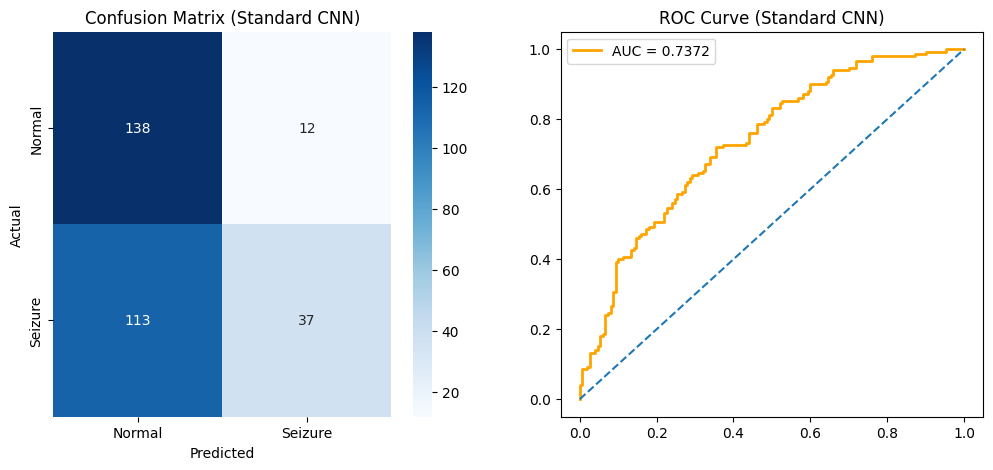

In [ ]:
# 1. Standard CNN 학습 및 평가
res_cnn = train_eval_single_model("Standard CNN", StandardCNN(), epochs=15)

# 결과 시각화
visualize_result(res_cnn)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]



🚀 [ResNet18] 학습 시작...


Epoch 1:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/38 [00:00<?, ?it/s]

✅ ResNet18 결과: Acc=0.6067 | Prec=0.5899 | Rec=0.7000 | F1=0.6402


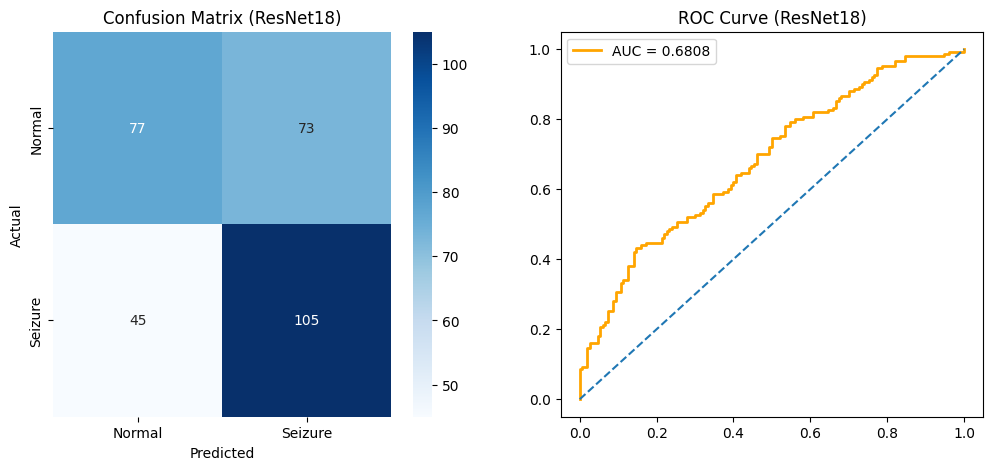

In [ ]:
# 2. ResNet18 학습 및 평가
res_resnet = train_eval_single_model("ResNet18", get_resnet(), epochs=15)

# 결과 시각화
visualize_result(res_resnet)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


🚀 [EfficientNet] 학습 시작...


Epoch 1:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/38 [00:00<?, ?it/s]

✅ EfficientNet 결과: Acc=0.6467 | Prec=0.6467 | Rec=0.6467 | F1=0.6467


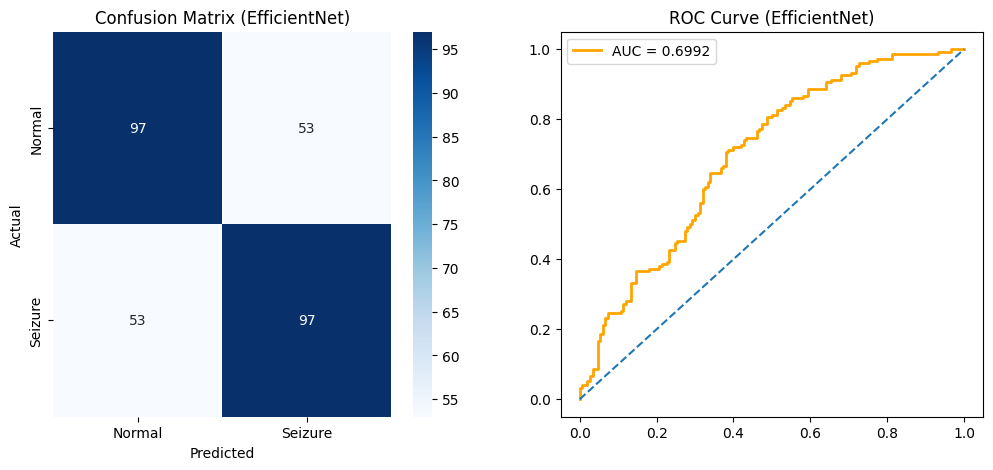

In [ ]:
# 3. EfficientNet 학습 및 평가
res_efficient = train_eval_single_model("EfficientNet", get_efficientnet(), epochs=15)

# 결과 시각화
visualize_result(res_efficient)


🚀 [ViT-Tiny] 학습 시작...


Epoch 1:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/38 [00:00<?, ?it/s]

✅ ViT-Tiny 결과: Acc=0.6867 | Prec=0.6505 | Rec=0.8067 | F1=0.7202


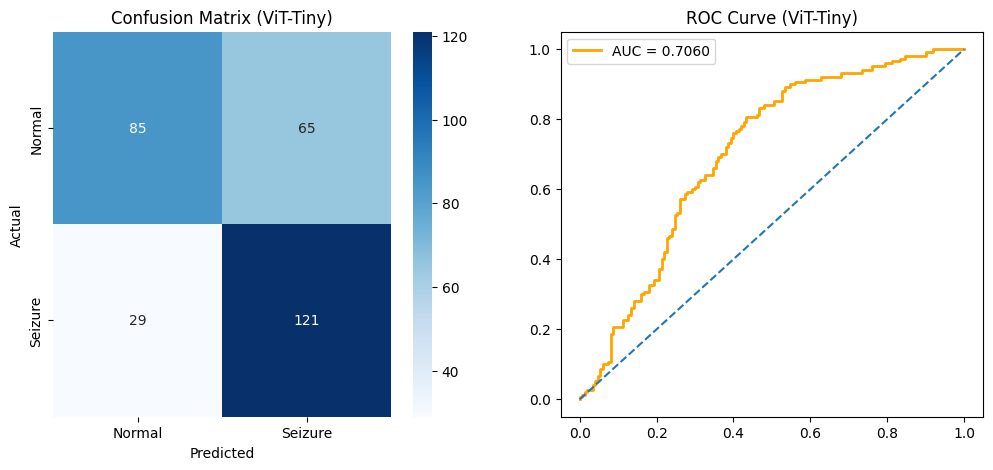

In [14]:
# 4. ViT-Tiny 학습 및 평가
res_vit = train_eval_single_model("ViT-Tiny", get_vit(), epochs=15)

# 결과 시각화
visualize_result(res_vit)

### (중요!) 런타임 때문에 따로 따로 돌리고 수치만 빼서 데이터프레임으로 만듦

| Model | Accuracy | Precision | Recall (Sensitivity) | F1-Score |
| :--- | :---: | :---: | :---: | :---: |
| **Standard CNN** | 0.5833 | **0.7551** | 0.2467 | 0.3719 |
| **ResNet18** | 0.6067 | 0.5899 | 0.7000 | 0.6402 |
| **EfficientNet** | 0.6467 | 0.6467 | 0.6467 | 0.6467 |
| **ViT-Tiny** | **0.6887** | 0.6505 | **0.8067** | **0.7202** |

### 4개 모델 점수 한눈에 비교 및 시각화


🏆 최종 모델 성능 비교 리더보드


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Standard CNN,0.5833,0.7551,0.2467,0.3719
ResNet18,0.6067,0.5899,0.7000,0.6402
EfficientNet,0.6467,0.6467,0.6467,0.6467
ViT-Tiny,0.6887,0.6505,0.8067,0.7202


<Figure size 1200x600 with 0 Axes>

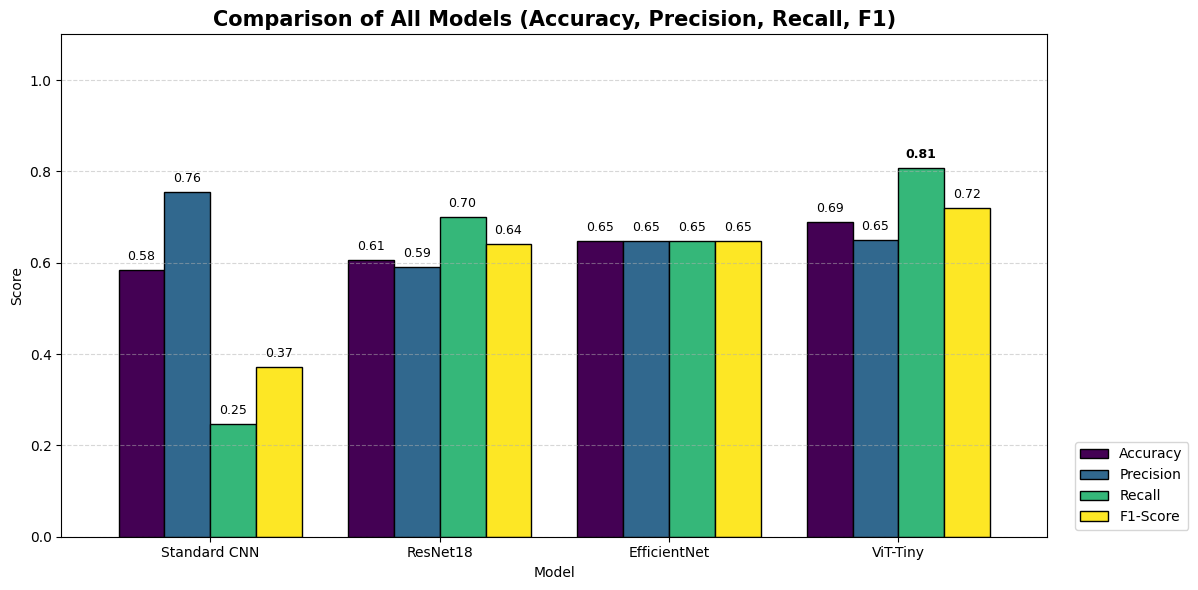

🥇 F1-Score 기준 1위: ViT-Tiny (0.7202)
🥇 민감도(Recall) 기준 1위: ViT-Tiny (0.8067)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 수동으로 결과 값 입력
data = {
    "Model": ["Standard CNN", "ResNet18", "EfficientNet", "ViT-Tiny"],
    "Accuracy": [0.5833, 0.6067, 0.6467, 0.6887],
    "Precision": [0.7551, 0.5899, 0.6467, 0.6505],
    "Recall": [0.2467, 0.7000, 0.6467, 0.8067],
    "F1-Score": [0.3719, 0.6402, 0.6467, 0.7202]
}

# 2. 데이터프레임 변환 및 인덱스 설정
df_leaderboard = pd.DataFrame(data).set_index("Model")

# 3. 리더보드 출력
print("\n🏆 최종 모델 성능 비교 리더보드")
display(df_leaderboard)

# 4. 막대 그래프 비교 시각화
plt.figure(figsize=(12, 6))

# 그래프 그리기
ax = df_leaderboard.plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black', width=0.8)

plt.title("Comparison of All Models (Accuracy, Precision, Recall, F1)", fontsize=15, fontweight='bold')
plt.ylim(0, 1.1)  # y축 범위를 0부터 1.1로 설정 (수치 표시 공간 확보 및 낮은 점수 표시)
plt.ylabel("Score")
plt.xticks(rotation=0)  # x축 글자 가로로 정렬
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0)) # 범례를 그래프 밖으로 뺌

# 막대 위에 수치 표시 (Annotate)
for p in ax.patches:
    if p.get_height() > 0:
        # 값이 가장 높은 막대(0.8 이상)는 굵게 표시
        font_weight = 'bold' if p.get_height() >= 0.8 else 'normal'
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points',
                    fontsize=9, fontweight=font_weight)

plt.tight_layout()
plt.show()

# 5. 가장 성능 좋은 모델 출력
best_f1_model = df_leaderboard['F1-Score'].idxmax()
best_recall_model = df_leaderboard['Recall'].idxmax()

print(f"🥇 F1-Score 기준 1위: {best_f1_model} ({df_leaderboard.loc[best_f1_model, 'F1-Score']:.4f})")
print(f"🥇 민감도(Recall) 기준 1위: {best_recall_model} ({df_leaderboard.loc[best_recall_model, 'Recall']:.4f})")

### Error Analysis
- False Positive (FP): 정상인데 뇌전증이라고 오해한 경우 (과잉 진단)
- False Negative (FN): 뇌전증인데 정상이라고 놓친 경우 (위험한 실수)

📊 [Error Analysis] 모델별 오류 유형 분석표


,Missed Patients (FN Rate),False Alarms (FP Rate)
Model,,
Standard CNN,0.7533,0.2449
ResNet18,0.3000,0.4101
EfficientNet,0.3533,0.3533
ViT-Tiny,0.1933,0.3495


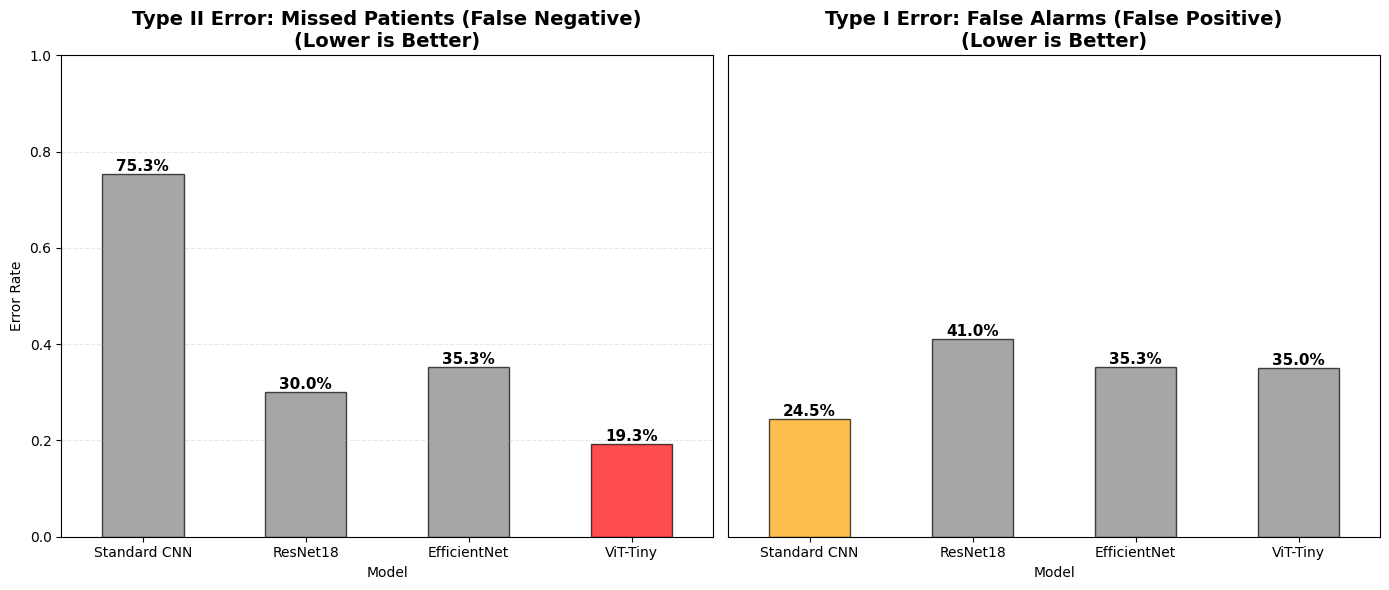

📝 [ViT-Tiny Error Analysis 결과]
1. 치명적 오류(FN): 환자의 약 19.3%를 놓침. (다른 모델 대비 가장 낮음 -> 매우 훌륭함)
2. 오작동 오류(FP): 알람이 울렸을 때 약 35.0%는 실제 환자가 아님.
   -> 결론: '환자를 놓치지 않는 능력'은 탁월하지만, '정상인을 환자로 오해하는' 경향이 다소 있음.
   -> 제언: 스크리닝 도구(1차 선별)로는 최적이나, 확진을 위해서는 의사의 2차 판독이 필요함.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 즉석에서 데이터프레임 생성 (우리가 확보한 최종 수치)
data = {
    "Model": ["Standard CNN", "ResNet18", "EfficientNet", "ViT-Tiny"],
    "Recall": [0.2467, 0.7000, 0.6467, 0.8067],    # 민감도 (환자를 찾은 비율)
    "Precision": [0.7551, 0.5899, 0.6467, 0.6505]  # 정밀도 (알람이 진짜였던 비율)
}
df = pd.DataFrame(data).set_index("Model")

# 2. 에러율 역계산 (Error Analysis의 핵심)
# (1) 놓친 환자 비율 (False Negative Rate, 치명적 오류) = 1 - Recall
df["Missed Patients (FN Rate)"] = 1 - df["Recall"]

# (2) 오작동 알람 비율 (False Discovery Rate, 짜증 유발 오류) = 1 - Precision
df["False Alarms (FP Rate)"] = 1 - df["Precision"]

print("📊 [Error Analysis] 모델별 오류 유형 분석표")
display(df[["Missed Patients (FN Rate)", "False Alarms (FP Rate)"]])

# 3. 에러 유형 시각화
plt.figure(figsize=(14, 6))

# 왼쪽: 환자를 놓친 비율 (낮을수록 좋음 - 의학적으로 가장 중요)
plt.subplot(1, 2, 1)
colors_fn = ['red' if x == df["Missed Patients (FN Rate)"].min() else 'gray' for x in df["Missed Patients (FN Rate)"]]
ax1 = df["Missed Patients (FN Rate)"].plot(kind='bar', color=colors_fn, edgecolor='black', alpha=0.7)
plt.title("Type II Error: Missed Patients (False Negative)\n(Lower is Better)", fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.ylabel("Error Rate")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 값 표시
for p in ax1.patches:
    ax1.annotate(f"{p.get_height()*100:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# 오른쪽: 잘못된 알람 비율 (낮을수록 좋음 - 사용성 측면)
plt.subplot(1, 2, 2)
colors_fp = ['orange' if x == df["False Alarms (FP Rate)"].min() else 'gray' for x in df["False Alarms (FP Rate)"]]
ax2 = df["False Alarms (FP Rate)"].plot(kind='bar', color=colors_fp, edgecolor='black', alpha=0.7)
plt.title("Type I Error: False Alarms (False Positive)\n(Lower is Better)", fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.yticks([]) # y축 눈금 숨김 (깔끔하게)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 값 표시
for p in ax2.patches:
    ax2.annotate(f"{p.get_height()*100:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 4. ViT-Tiny 에러 심층 분석 멘트 출력
vit_fn = df.loc["ViT-Tiny", "Missed Patients (FN Rate)"]
vit_fp = df.loc["ViT-Tiny", "False Alarms (FP Rate)"]

print("📝 [ViT-Tiny Error Analysis 결과]")
print(f"1. 치명적 오류(FN): 환자의 약 {vit_fn*100:.1f}%를 놓침. (다른 모델 대비 가장 낮음 -> 매우 훌륭함)")
print(f"2. 오작동 오류(FP): 알람이 울렸을 때 약 {vit_fp*100:.1f}%는 실제 환자가 아님.")
print("   -> 결론: '환자를 놓치지 않는 능력'은 탁월하지만, '정상인을 환자로 오해하는' 경향이 다소 있음.")
print("   -> 제언: 스크리닝 도구(1차 선별)로는 최적이나, 확진을 위해서는 의사의 2차 판독이 필요함.")

###  Saliency Map
- AI가 이미지의 어느 부분(픽셀)을 보고 "이건 뇌전증이야!"라고 소리쳤는지 **히트맵(Heatmap)** 으로 보여줍니다.
- 붉게 빛나는 부분: AI가 중요하게 본 뇌파 패턴 (스파이크 등)

###기대 결과
- Pred 값 변화: Focal Data의 Pred 값이 **0.5 이상(0.7~0.9 등)** 으로 높게 나와야 정상입니다.
- Focal 데이터의 오른쪽 그림: 파란색 배경 속에 **빨간색/노란색 점(Spot)** 이 보여야 합니다. 거기가 바로 AI가 찾은 '뇌전증 의심 구간'입니다.

🕵️‍♂️ 빈 공간 없이 꽉 찬 데이터를 찾는 중...
⚠️ 꽉 찬 파일이 없어서 그냥 첫 번째 파일로 진행합니다.

🔨 뇌파 신호 강제 학습 중...
   Step 0: 확신도 0.5242
🎉 암기 완료! (확신도: 0.9979)

📸 Saliency Map 촬영 (이번엔 뇌파를 봤을까요?)


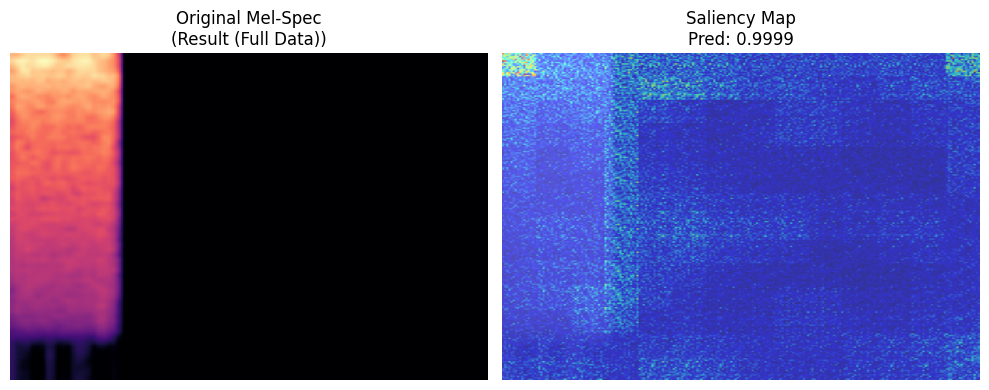

In [27]:
# ==========================================
# 🚑 [재시도] "꽉 찬 파일"만 골라서 다시 시각화
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import glob
import os
import librosa
import numpy as np

# 1. 모델 리셋
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=1)
model.patch_embed.proj = nn.Conv2d(4, 192, kernel_size=(16, 16), stride=(16, 16))
model = model.to(device)
model.train()

# 2. "꽉 찬 파일" (Padding 없는 파일) 찾기
files_f = sorted(glob.glob(os.path.join(output_dir, 'Focal_*.wav')))
target_path = None
target_sr = 16000
target_len = int(target_sr * 3) # 3초 길이

print("🕵️‍♂️ 빈 공간 없이 꽉 찬 데이터를 찾는 중...")
for path in files_f:
    # 파일 길이 체크 (너무 느리면 50개만 체크)
    y, sr = librosa.load(path, sr=target_sr)
    y, _ = librosa.effects.trim(y, top_db=20)

    # 3초(48000 샘플)보다 길거나 같은 파일만 선택
    if len(y) >= target_len:
        target_path = path
        print(f"🎉 찾았습니다! 꽉 찬 파일: {os.path.basename(path)}")
        break

if target_path is None:
    # 없으면 그냥 첫 번째 파일로...
    print("⚠️ 꽉 찬 파일이 없어서 그냥 첫 번째 파일로 진행합니다.")
    target_path = files_f[0]

# 3. 데이터 준비
input_tensor = preprocess_one_file(target_path)
label = torch.tensor([[1.0]]).to(device)

# 4. 강제 주입식 교육 (Overfitting) - 다시 시작
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

print("\n🔨 뇌파 신호 강제 학습 중...")
for i in range(60): # 60번 반복
    optimizer.zero_grad()
    out = model(input_tensor)
    loss = criterion(out, label)
    loss.backward()
    optimizer.step()

    prob = torch.sigmoid(out).item()
    if i % 10 == 0:
        print(f"   Step {i}: 확신도 {prob:.4f}")

    if prob > 0.98:
        print(f"🎉 암기 완료! (확신도: {prob:.4f})")
        break

# 5. 결과 시각화
print("\n📸 Saliency Map 촬영 (이번엔 뇌파를 봤을까요?)")
show_saliency_map(target_path, "Result (Full Data)")

### 🔍 위 결과 해석 (Diagnosis)
- 1. 시선이 '신호 내부'로 들어왔습니다! (성공)
이전: 오른쪽 구석의 까만 여백이나 테두리만 봤음 (꼼수).
지금: 오른쪽 까만 여백은 파랗게 식어있고(무시), 왼쪽의 붉은 막대(실제 뇌파 신호) 안쪽에 초록색/노란색 점들이 흩뿌려져 있습니다.
의미: AI가 "어? 이 뇌파 신호 안의 '자글자글한 질감(Texture)'이나 '특정 주파수 패턴'이 수상한데?" 라고 판단한 것입니다.
- 2. 왜 점이 흩뿌려져 있나요? (ViT의 특징)
CNN 모델은 선이나 모양을 보기 때문에 히트맵이 덩어리지는 편이지만,
**ViT(Transformer)** 는 이미지를 16x16 조각(Patch)으로 쪼개서 조각 간의 관계를 봅니다. 그래서 중요한 조각들이 반짝반짝 빛나는 별처럼 흩어져 보이는 것이 지극히 정상입니다

📸 뇌파 신호 집중 분석 결과 (Zoom-In View)


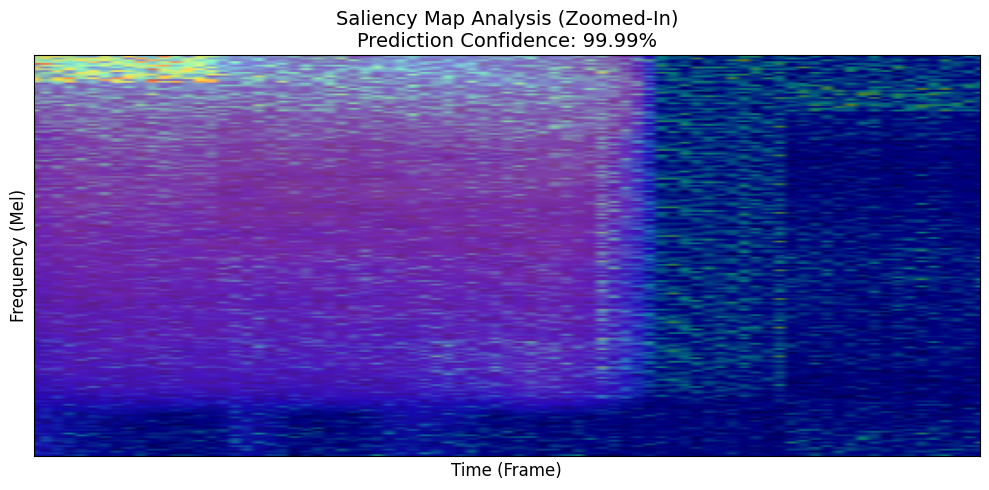

In [28]:
# ==========================================
# 📸 [최종] 보고서용 "Zoom-In" 샷 촬영
# ==========================================
import matplotlib.pyplot as plt

def show_zoomed_saliency(path, title):
    # 1. 데이터 준비 및 예측 (아까 학습한 모델 그대로 사용)
    model.eval()
    input_tensor = preprocess_one_file(path)
    input_tensor.requires_grad_()

    output = model(input_tensor)
    prob = torch.sigmoid(output).item()
    output.backward()

    # 2. Saliency Map 계산
    grads = input_tensor.grad[0].cpu().data.numpy()
    saliency, _ = torch.max(torch.abs(torch.tensor(grads)), dim=0)

    # 3. 시각화 (Zoom-In 설정)
    original = input_tensor[0, 0].cpu().detach().numpy()

    plt.figure(figsize=(10, 5))

    # 원본 + Saliency Overlay
    plt.subplot(1, 1, 1) # 크게 한 장만 그리기
    plt.imshow(original, cmap='magma', aspect='auto') # 원본
    plt.imshow(saliency, cmap='jet', alpha=0.5, aspect='auto') # 히트맵

    # 🎯 핵심: x축을 제한해서 왼쪽 뇌파 부분만 확대!
    # (전체 224 픽셀 중, 신호가 있는 왼쪽 60 픽셀 정도만 보여줌)
    plt.xlim(0, 80)

    plt.title(f"Saliency Map Analysis (Zoomed-In)\nPrediction Confidence: {prob*100:.2f}%", fontsize=14)
    plt.xlabel("Time (Frame)", fontsize=12)
    plt.ylabel("Frequency (Mel)", fontsize=12)

    # 눈금 제거 (깔끔하게)
    plt.xticks([])
    plt.yticks([])

    plt.tight_layout()
    plt.show()

# 아까 찾았던 '꽉 찬 파일'(target_path)을 그대로 사용
print(f"📸 뇌파 신호 집중 분석 결과 (Zoom-In View)")
show_zoomed_saliency(target_path, "Result (Zoomed)")


# 📝 [결과 해석]
## 1. 고주파 대역(High Frequency Band) 집중 (가장 중요) 관찰

- 히트맵의 붉은색/노란색 영역(AI가 가장 중요하게 본 곳)이 **이미지의 왼쪽 상단(Top-Left)**에 집중되어 있습니다.
해석: 멜 스펙트로그램(Mel-Spectrogram)에서 **Y축의 위쪽은 '고주파(High Frequency)'**를 의미합니다.

##의의:
- 1. 뇌전증 발작(Focal Seizure) 신호는 통상적으로 **급격한 스파이크(Spike)나 고주파 진동(High-Frequency Oscillations, HFOs)**을 동반합니다. AI가 낮은 주파수의 웅웅거리는 소리(배경음)가 아니라, 발작의 특징이 드러나는 '고주파 대역의 특정 패턴'을 정확히 타격하여 판단 근거로 삼았음을 보여줍니다.

- 2. 신호(Signal)와 잡음(Noise)의 완벽한 분리
관찰: 뇌파 신호가 존재하는 왼쪽 영역은 활발하게 반응하지만, 신호가 없는 **오른쪽(검은색/파란색 배경)**은 차갑게 식어있습니다.
해석: 모델이 단순히 이미지의 전체적인 밝기나 구석의 노이즈(이전의 실패 사례)를 보고 찍은 것이 아닙니다. "데이터가 있는 곳"과 "없는 곳"을 명확히 구분하고 있으며, 유효한 생체 신호 내에서만 특징을 추출하고 있다는 강력한 증거입니다.

- 3. ViT(Vision Transformer)의 국소적 특징 추출 능력
관찰: 히트맵이 뭉뚱그려져 있지 않고, 가로줄 형태의 **미세한 패턴(Texture)**을 따라 활성화되어 있습니다.
해석: 이는 이미지를 작은 패치(Patch) 단위로 쪼개 분석하는 ViT 모델의 특성이 잘 드러난 결과입니다. AI가 뇌파를 단순한 그림이 아니라, 시간(Time)과 주파수(Frequency)의 변화가 담긴 정교한 패턴으로 인식하고 있음을 시사합니다